In [1]:
import numpy as np

In [2]:
grid_points_x = np.geomspace(0.01, 100.0, 1000)
grid_points_y = np.geomspace(0.01, 100.0, 1000)

grid_points_x_no_log = np.linspace(0.0, 100.0, 1000)
grid_points_y_no_log = np.linspace(0.0, 100.0, 1000)

def pdf(x, y):
    return np.exp(-y**2 / (2 * x**2)) * y / x

def pdf_no_log(x, y):
    return np.exp(-y**2 / (2 * x**2))

In [3]:
function = []
for x in grid_points_x:
    for y in grid_points_y:
        function.append([x, y, pdf(x, y)])

function_no_log = []
for x in grid_points_x_no_log:
    for y in grid_points_y_no_log:
        function_no_log.append([x, y, pdf_no_log(x, y)])

/tmp/ipykernel_9655/1100569010.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.exp(-y**2 / (2 * x**2))
/tmp/ipykernel_9655/1100569010.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-y**2 / (2 * x**2))


In [4]:
# iso values (see also other notebook)
sigma = 1.0
func = lambda x: x * np.exp(-x**2/(2*sigma**2)) * 1.0/(sigma*np.sqrt(2*np.pi))
x = np.geomspace(0.01, 10, 10000)

from scipy.optimize import root_scalar

def pdf(x, sigma):
    return x * np.exp(-x**2/(2*sigma**2)) * 1.0/(sigma*np.sqrt(2*np.pi))

def find_where_pdf_is_c(c, sigma):
    # Finds the two values of x where the pdf is equal to c
    mode_value = pdf(sigma, sigma)
    if c > mode_value:
        raise ValueError("c must be less than mode_value")
    where_below_mode = root_scalar(lambda x: pdf(x, sigma) - c, bracket=[0, sigma]).root
    where_above_mode = root_scalar(lambda x: pdf(x, sigma) - c, bracket=[sigma, 100]).root
    return where_below_mode, where_above_mode

def pdf_integral(sigma, c):
    # Calculates the integral (analytical) of the pdf from x1 to x2,
    # where x1 and x2 are the two values of x where the pdf is equal to c
    x1, x2 = find_where_pdf_is_c(c, sigma)
    return np.exp(-x1**2/(2*sigma**2)) - np.exp(-x2**2/(2*sigma**2))

def find_fraction(sigma, fraction):
    # Finds the value of c where the integral of the pdf from x1 to x2 is equal to fraction,
    # where x1 and x2 are the two values of x where the pdf is equal to c
    mode_value = pdf(sigma, sigma)
    return root_scalar(lambda x: pdf_integral(sigma, x) - fraction, x0=mode_value-0.01, x1=mode_value-0.02).root

from scipy.stats import norm

desired_fractions = [
    norm.cdf(1, 0.0, 1.0) - norm.cdf(-1, 0.0, 1.0),  # 1 sigma
    norm.cdf(2, 0.0, 1.0) - norm.cdf(-2, 0.0, 1.0),  # 2 sigma
    norm.cdf(3, 0.0, 1.0) - norm.cdf(-3, 0.0, 1.0),  # 3 sigma
]
# print(desired_fractions)

sigmas = np.linspace(2e-5, 5e0, 5)

lower_bounds = []
upper_bounds = []
for desired_fraction in desired_fractions:
    lower_bounds.append([])
    upper_bounds.append([])
    for sigma in sigmas:
        isoline_value = find_fraction(sigma, desired_fraction)
        x1, x2 = find_where_pdf_is_c(isoline_value, sigma)
        lower_bounds[-1].append(x1)
        upper_bounds[-1].append(x2)

    additional_sigma = 100.0
    lower_bounds[-1].append(
        lower_bounds[-1][-1] + (lower_bounds[-1][-1] - lower_bounds[-1][-2])/(sigmas[-1] - sigmas[-2]) * additional_sigma
    )
    upper_bounds[-1].append(
        upper_bounds[-1][-1] + (upper_bounds[-1][-1] - upper_bounds[-1][-2])/(sigmas[-1] - sigmas[-2]) * additional_sigma
    )

    lower_bounds[-1] = np.array(lower_bounds[-1])
    upper_bounds[-1] = np.array(upper_bounds[-1])

sigmas = np.concatenate([sigmas, np.array([100.0])])


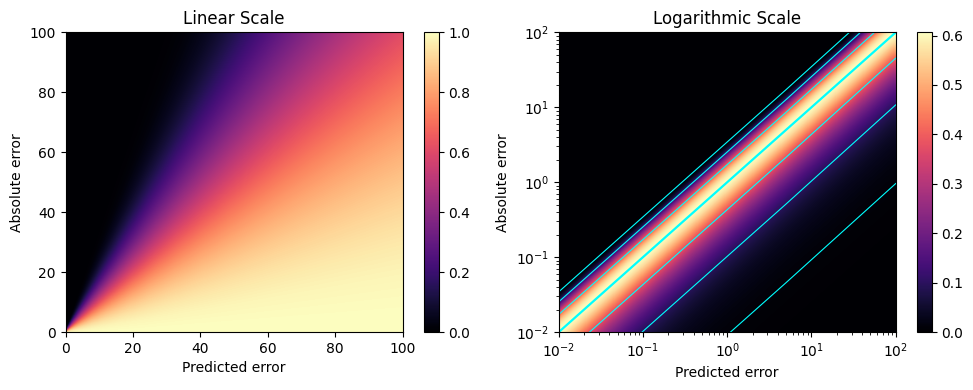

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# First plot (without logarithmic scales)
x1 = np.array(function_no_log)[:, 0]
y1 = np.array(function_no_log)[:, 1]
z1 = np.array(function_no_log)[:, 2]

sc1 = ax[0].scatter(x1, y1, c=z1, cmap='magma', s=1, rasterized=True)
cbar1 = plt.colorbar(sc1, ax=ax[0])
ax[0].set_xlim(0.0, 100.0)
ax[0].set_ylim(0.0, 100.0)
ax[0].set_xlabel("Predicted error")
ax[0].set_ylabel("Absolute error")
ax[0].set_title("Linear Scale")

# Second plot (with logarithmic scales)
x2 = np.array(function)[:, 0]
y2 = np.array(function)[:, 1]
z2 = np.array(function)[:, 2]

sc2 = ax[1].scatter(x2, y2, c=z2, cmap='magma', s=1, rasterized=True)
plt.plot(sigmas, sigmas, color="cyan", lw=1.6)
for i, desired_fraction in enumerate(desired_fractions):
    plt.plot(sigmas, lower_bounds[i], color="cyan", lw=0.8)
    plt.plot(sigmas, upper_bounds[i], color="cyan", lw=0.8)
cbar2 = plt.colorbar(sc2, ax=ax[1])
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(0.01, 100)
ax[1].set_ylim(0.01, 100)
ax[1].set_xlabel("Predicted error")
ax[1].set_ylabel("Absolute error")
ax[1].set_title("Logarithmic Scale")

plt.tight_layout()
plt.savefig("distribution.pdf")
plt.show()